In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from smoothdiff import *

DEVICE = "mps"

In [3]:
# Load Model
model = torchvision.models.vgg16(weights="IMAGENET1K_V1")

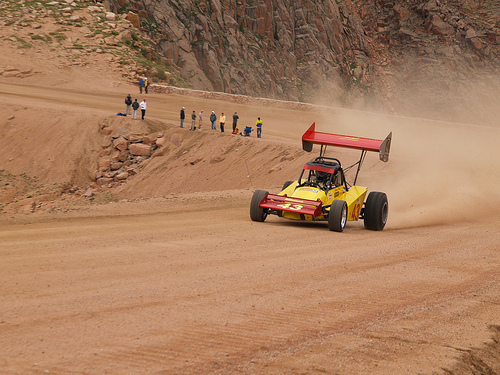

In [4]:
# Load input image
img = Image.open("assets/car.jpg")
img = img.convert("RGB")
img

In [5]:
# Apply preprocessing to image
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

inputs = preprocess(img).unsqueeze(0).to(DEVICE)
inputs.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# Run SmoothDiff
def smoothdiff_explanation(model, inputs, n_samples=20, std=0.5):
    # Replacing non-linear functions by ones that compute VEJPs on the backward-pass
    model = replace_nonlinear_layers(model)
    model.to(DEVICE).eval()

    # Step 1: Compute n forward passes
    set_smoothdiff_layer_mode(model, collect_stats=True, smooth_backward=False)
    with torch.no_grad():
        for _ in range(n_samples):
            model(inputs + torch.randn_like(inputs) * std)

    # Step 2: Compute single SmoothDiff backward-pass (VEJPs)
    set_smoothdiff_layer_mode(model, collect_stats=False, smooth_backward=True)
    inputs = inputs.clone().detach().requires_grad_(True).to(DEVICE)  # Y'all should really give Julia a shot!
    y = model(inputs)
    y.max().backward()  # explain w.r.t. maximally activated output neuron

    attribution = inputs.grad.clone().cpu().detach().numpy()
    return attribution

In [7]:
# In case you are curious about the layers SmoothDiff replaces:
replace_nonlinear_layers(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SmoothReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): SmoothReLU()
    (4): SmoothMaxPool2d()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): SmoothReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): SmoothReLU()
    (9): SmoothMaxPool2d()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): SmoothReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): SmoothReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): SmoothReLU()
    (16): SmoothMaxPool2d()
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): SmoothReLU()
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): Smoot

In [8]:
# Heatmapping utilities
def pool(attribution: np.ndarray) -> np.ndarray:
    """
    Pool attributions by computing the norm over color channels
    (summation should not be used for sensitivity-based methods).
    """
    assert attribution.shape == (3, 224, 224), (
        f"Shape mismatch: expected (3, 224, 224), got {attribution.shape}"
    )
    return np.linalg.norm(attribution, axis=0)


def normalize(attribution: np.ndarray, percentile=99.9) -> np.ndarray:
    """
    Normalize by max-abs. value of attribution, removing outliers by computing the 99.9th percentile of values.
    """
    absmax = np.percentile(np.abs(attribution), percentile)
    return np.clip(attribution / absmax, a_min=-1.0, a_max=1.0)


def heatmap(ax, attribution):
    return ax.imshow(normalize(pool(attribution)), cmap=cmc.batlow, vmin=0.0, vmax=1.0)

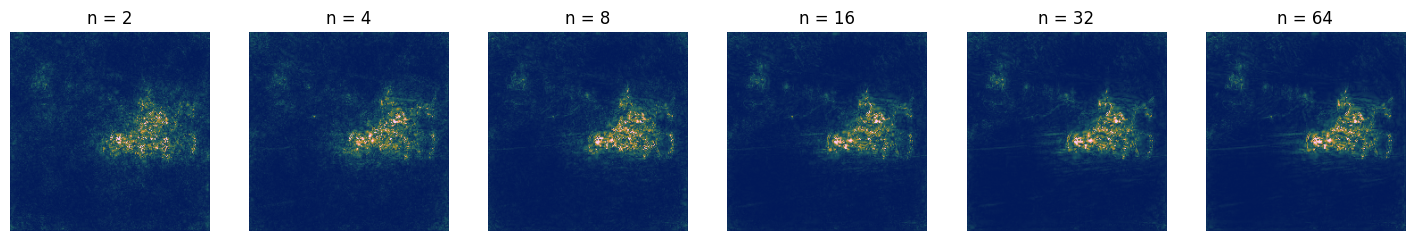

In [9]:
# Plot SmoothDiff explanations over increasing sample sizes
std = 0.5
ns = [2, 4, 8, 16, 32, 64]

fig, axes = plt.subplots(ncols=len(ns), figsize=(18, 3))
for i, n_samples in enumerate(ns):
    ax = axes[i]
    attribution = smoothdiff_explanation(model, inputs, n_samples, std)
    heatmap(ax, attribution[0])
    ax.title.set_text(f"n = {n_samples}")
    ax.axis("off")